# Neural Machine Translation ( English - Telugu )

Machine translation is a challenging task that traditionally involves large statistical models developed using highly sophisticated linguistic knowledge.

Neural machine translation is the use of deep neural networks for the problem of machine translation.

In this Notebook, we have developed a neural machine translation system for translating English phrases to Telugu.

Steps:

* Prepare Data
* Preprocess Data
* Text to Sequence Conversion
* Build Encoder-Decoder Model
* Train Model
* Translate English to Telugu

In this Notebook, The [English-Telugu](https://github.com/SRIDEV93/Language-Translation-Using-Machine-Learning-Telugu-to-English-/blob/main/English.txt) Bilingual-Sentence-Pairs data is used for Neural Machine Translation.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# List files in your Drive
import os
os.listdir('/content/drive/My Drive/')

['Getting started.pdf',
 'Untitled spreadsheet (1).gsheet',
 '53527669_ticket.pdf',
 'Untitled spreadsheet.xlsx',
 'resume.pdf',
 'memory challenge 2020.gdoc',
 'AUCTION WAR-2020.gdoc',
 'QUIZZAIRE 2020.gdoc',
 '6 class.gdoc',
 'Untitled spreadsheet.gsheet',
 'Colab Notebooks',
 'deep_learning',
 'NLP -1',
 'Untitled presentation.gslides',
 'demo',
 'braminen',
 'dl_project']

In [4]:
project_path = ""

In [5]:
import pandas as pd
import string
from string import digits
import re
import os
from numpy import array, argmax, random, take
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector,TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
# pd.set_option('display.max_colwidth', 200)

## Load Data

In [6]:
# Function to load sentences from a text file
english_file_path = "/content/drive/MyDrive/NLP -1/English-Telugu-20241116T070209Z-001 (3)/English-Telugu-20241116T070209Z-001/English.txt"
telugu_file_path = "/content/drive/MyDrive/NLP -1/English-Telugu-20241116T070209Z-001 (3)/English-Telugu-20241116T070209Z-001/Telugu.txt"

# Load existing English and Telugu data
with open(english_file_path, 'r', encoding='utf-8') as en_file, open(telugu_file_path, 'r', encoding='utf-8') as te_file:
    english_sentences = en_file.readlines()
    telugu_sentences = te_file.readlines()

# Ensure the datasets have the same number of sentences
assert len(english_sentences) == len(telugu_sentences), "Mismatch in number of English and Telugu sentences."

# Combine English and Telugu sentences into a single dataset
data = list(zip(english_sentences, telugu_sentences))

print(f"Total English sentences: {len(english_sentences)}")
print(f"Total Telugu sentences: {len(telugu_sentences)}")


Total English sentences: 148441
Total Telugu sentences: 148441


In [7]:
data = pd.DataFrame({"english_sentences":english_sentences,"telugu_sentences":telugu_sentences})

In [8]:
data.head()

,english_sentences,telugu_sentences
0,His legs are long.\n,అతని కాళ్ళు పొడవుగా ఉన్నాయి.\n
1,I swim in the sea every day.\n,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను.\n
2,Tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్...
3,Smoke filled the room.\n,పొగ గదిని నింపింది.\n
4,Tom and Mary understood each other.\n,టామ్ మరియు మేరీ ఒకరినొకరు అర్థం చేసుకున్నార...


data.shape

## Data Pre-Processing

#### Text Cleaning

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [11]:
# clean english sentences
def clean_eng(text):
    # Lowercase all characters
    text = text.lower()
    # map contractions
    text = ' '.join([contraction_mapping[w] if w in contraction_mapping else w for w in text.split(" ")])
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove extra spaces
    text= text.strip()

    return text

In [12]:
# clean telugu sentences
def clean_tel(text):
    # Lowercase all characters
    text = text.lower()
    # Remove quotes
    text = re.sub("'", '', text)
    # Remove all the special characters
    exclude = set(string.punctuation) # Set of all special characters
    text = ''.join([c for c in text if c not in exclude])
    # Remove all numbers from text
    remove_digits = str.maketrans('', '', digits)
    text = text.translate(remove_digits)
    # Remove Telugu numbers from text
    text = re.sub("[౦౧౨౩౪౫౬౭౮౯]", '', text)
    # Remove extra spaces
    text= text.strip()

    return text

In [13]:
# Copy data to a new DataFrame for cleaning
data_df = data.copy()

# Apply cleaning functions to English and Telugu sentences
data_df["english_sentences"] = data_df["english_sentences"].apply(lambda x: clean_eng(x))
data_df["telugu_sentences"] = data_df["telugu_sentences"].apply(lambda x: clean_tel(x))

# Filter out rows where either English or Telugu sentence is empty
data_df = data_df[
    (data_df["english_sentences"].str.strip() != "") &
    (data_df["telugu_sentences"].str.strip() != "")
]

# Print the number of valid sentence pairs after filtering
print(f"Number of valid sentence pairs after cleaning and filtering: {len(data_df)}")


Number of valid sentence pairs after cleaning and filtering: 148441


In [14]:
data_df.head()

,english_sentences,telugu_sentences
0,his legs are long,అతని కాళ్ళు పొడవుగా ఉన్నాయి
1,i swim in the sea every day,నేను ప్రతి రోజు సముద్రంలో ఈత కొడతాను
2,tom popped into the supermarket on his way hom...,టామ్ కొంచెం పాలు కొనడానికి ఇంటికి వెళ్ళేటప్పుడ...
3,smoke filled the room,పొగ గదిని నింపింది
4,tom and mary understood each other,టామ్ మరియు మేరీ ఒకరినొకరు అర్థం చేసుకున్నారు


#### Text to Sequence Conversion

Maximum sentence length in English: 101
Maximum sentence length in Telugu: 27


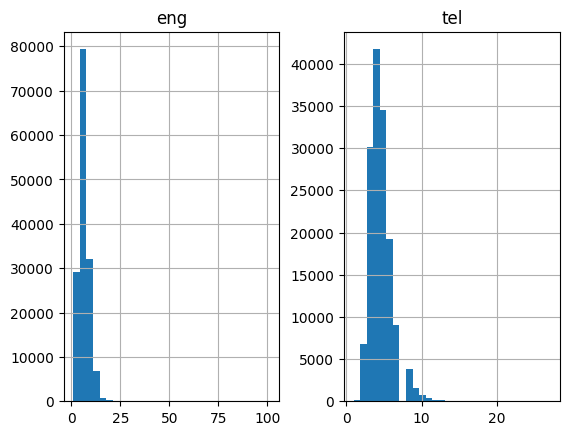

In [15]:
# empty lists
eng_l = []
tel_l = []

# populate the lists with sentence lengths
for i in data_df["english_sentences"].values:
    eng_l.append(len(i.split()))

for i in data_df["telugu_sentences"].values:
    tel_l.append(len(i.split()))

# Create a DataFrame
length_df = pd.DataFrame({'eng': eng_l, 'tel': tel_l})

# Find and print max lengths
max_eng_length = max(eng_l)
max_tel_length = max(tel_l)

print(f"Maximum sentence length in English: {max_eng_length}")
print(f"Maximum sentence length in Telugu: {max_tel_length}")

# Plot histograms
length_df.hist(bins=30)
plt.show()


Quite intuitive – the maximum length of the Telugu sentences is 101 and that of the English phrases is 27.

Next, we vectorized our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.

Note that we prepared tokenizers for both the Telugu and English sentences:

In [16]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
# prepare english tokenizer
eng_tokenizer = tokenization(data_df["english_sentences"])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 101
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 13620


In [18]:
# prepare Telugu tokenizer
tel_tokenizer = tokenization(data_df["telugu_sentences"])
tel_vocab_size = len(tel_tokenizer.word_index) + 1

tel_length = 27
print('Telugu Vocabulary Size: %d' % tel_vocab_size)

Telugu Vocabulary Size: 38055


The below code block contains a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

We will now split the data into train and test set for model training and evaluation, respectively.

In [20]:
# split data into train and test set
train, test = train_test_split(data_df, test_size=0.1, random_state = 12)

Now, here We are encoding our **English sentences as the input sequences** and **Telugu sentences as the target sequences**. This is done for both the train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train["english_sentences"])
trainY = encode_sequences(tel_tokenizer, tel_length, train["telugu_sentences"])

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test["english_sentences"])
testY = encode_sequences(tel_tokenizer, tel_length, test["telugu_sentences"])

In [22]:
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1], 1))
testY = testY.reshape((testY.shape[0], testY.shape[1], 1))


In [23]:
trainX.shape,trainY.shape,testX.shape,testY.shape

((133596, 101), (133596, 27, 1), (14845, 101), (14845, 27, 1))

## Building Model

For the encoder, we are using embedding layer and Multilayer Bidirectional LSTM layer
For the decoder, we are using Multilayer LSTM layer followed by a dense layer

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed

def define_bidirectional_lstm_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    # Encoder
    encoder_inputs = Input(shape=(in_timesteps,))
    encoder_embedding = Embedding(input_dim=in_vocab, output_dim=units, mask_zero=True)(encoder_inputs)

    # Multilayer Bidirectional LSTM for Encoder
    encoder_bi_lstm1 = Bidirectional(LSTM(units, return_sequences=True, use_cudnn=False))(encoder_embedding)
    encoder_bi_lstm2 = Bidirectional(LSTM(units, return_sequences=False, use_cudnn=False))(encoder_bi_lstm1)

    # Decoder
    decoder_inputs = RepeatVector(out_timesteps)(encoder_bi_lstm2)
    decoder_lstm1 = LSTM(units, return_sequences=True, use_cudnn=False)(decoder_inputs)
    decoder_lstm2 = LSTM(units, return_sequences=True, use_cudnn=False)(decoder_lstm1)
    decoder_dense = TimeDistributed(Dense(out_vocab, activation='softmax'))(decoder_lstm2)

    # Define the model
    model = Model(encoder_inputs, decoder_dense)
    return model




In [26]:
print(f"trainX shape: {trainX.shape}")
print(f"trainY shape: {trainY.shape}")


trainX shape: (133596, 101)
trainY shape: (133596, 27, 1)


In [27]:
# model compilation
model = define_bidirectional_lstm_model(eng_vocab_size,tel_vocab_size,eng_length,tel_length, 256)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 101)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 101, 256)       │      3,486,720 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 101)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 101, 512)       │      1,050,624 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 512)            │      1,574,912 │ bidirectional[0][0],   │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 27, 512)        │              0 │ bidirectional_1[0][0]  │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 27, 256)        │        787,456 │ repeat_vector[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 27, 256)        │        525,312 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 27, 38055)      │      9,780,135 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,205,159 (65.63 MB)

 Trainable params: 17,205,159 (65.63 MB)

 Non-trainable params: 0 (0.00 B)

We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural networks.

In [28]:
rms = optimizers.RMSprop()
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used ‘sparse_categorical_crossentropy‘ as the loss function. This is because the function allows us to use the target sequence as is, instead of the one-hot encoded format. **One-hot encoding the target sequences using such a huge vocabulary might consume our system’s entire memory**.


**We will train it for 70 epochs and with a batch size of 64 with a validation split of 20%.** 80% of the data will be used for training the model and the rest for evaluating it.

We will also use the **ModelCheckpoint()** function to save the model with the lowest validation loss. Instead of Early Stopping we used this.

In [29]:
# Defining a helper function to save the model after each epoch
# in which the loss decreases
filepath = project_path+'NMT_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time
# the learning plateaus
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint, reduce_alpha]

## Train Model

Comparision of training loss and the validation loss.

In [32]:
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=70, batch_size=64, validation_split = 0.2,callbacks=callbacks, verbose=1)

Epoch 1/70
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.7541
Epoch 1: val_loss improved from inf to 1.24258, saving model to NMT_model.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 131s 73ms/step - loss: 1.7538 - val_loss: 1.2426 - learning_rate: 0.0010
Epoch 2/70
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.2345
Epoch 2: val_loss improved from 1.24258 to 1.23634, saving model to NMT_model.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 121s 72ms/step - loss: 1.2345 - val_loss: 1.2363 - learning_rate: 0.0010
Epoch 3/70
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.2154
Epoch 3: val_loss improved from 1.23634 to 1.19936, saving model to NMT_model.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 121s 73ms/step - loss: 1.2154 - val_loss: 1.1994 - learning_rate: 0.0010
Epoch 4/70
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.1813
Epoch 4: val_loss improved from 1.19936 to 1.17849, saving model to NMT_model.keras
1670/1670 ━━━━━━━━━━━━━━━━━━━━ 121s 72ms/step - loss: 1.1813 - val_loss: 1.1

In [33]:
import keras

In [34]:
# Save the model
model.save("translation_model.h5")

# Save the tokenizers
import pickle
with open("eng_tokenizer.pkl", "wb") as eng_file:
    pickle.dump(eng_tokenizer, eng_file)

with open("tel_tokenizer.pkl", "wb") as tel_file:
    pickle.dump(tel_tokenizer, tel_file)

# Save training history
with open("training_history.pkl", "wb") as history_file:
    pickle.dump(history.history, history_file)


In [35]:
# model = keras.saving.load_model("/kaggle/working/NMT_model.keras")

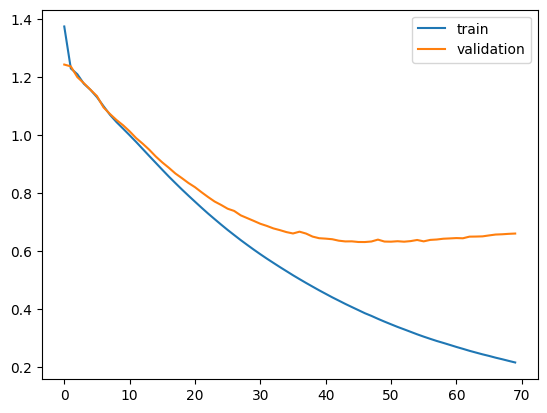

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

# Calculating BERT Score on Test Data

In [37]:
# Function to decode sequences
# Function to decode a sequence of indices into text
def decode_sequence(tokenizer, sequence):
    if len(sequence.shape) == 1:  # Ensure the input is a list of sequences
        sequence = [sequence]
    return tokenizer.sequences_to_texts(sequence)[0]  # Decode and return the first element


# Generate predictions on the test set
def test_data_generator(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Generate predictions using the generator
batch_size = 8
predictions = []
for batch in test_data_generator(testX, batch_size):
    batch_predictions = model.predict(batch, batch_size=batch_size)
    predictions.extend(batch_predictions)


# Decode predictions and ground truth
decoded_preds = []
decoded_targets = []

for i in range(len(predictions)):
    # Decode prediction
    pred_sequence = predictions[i].argmax(axis=-1)
    decoded_preds.append(decode_sequence(tel_tokenizer, pred_sequence))

    # Decode ground truth
    target_sequence = testY[i].flatten()
    decoded_targets.append(decode_sequence(tel_tokenizer, target_sequence))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [40]:
from bert_score import score

# Calculate BERTScore
P, R, F1 = score(decoded_preds, decoded_targets, lang="te", rescale_with_baseline=True)

# Display the average scores
print(f"Average Precision: {P.mean().item()}")
print(f"Average Recall: {R.mean().item()}")
print(f"Average F1 Score: {F1.mean().item()}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Average Precision: 0.8658366799354553
Average Recall: 0.8425914645195007
Average F1 Score: 0.8535867929458618


In [39]:
pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.3 MB/s eta 0:00:00


In [41]:
import pandas as pd

# Combine predictions, targets, and scores into a DataFrame
results_df = pd.DataFrame({
    "Prediction": decoded_preds,
    "Target": decoded_targets,
    "Precision": P.tolist(),
    "Recall": R.tolist(),
    "F1": F1.tolist(),
})

# Save to CSV for analysis
results_df.to_csv("bert_score_results.csv", index=False)

# Display the first few rows
print(results_df.head())


                                          Prediction  \
0                             నేను నేనే చేయలేకపోయాను   
1  పిల్లులు సోదరీమణులు ఎందుకు ఆశ్చర్యపోతున్నాను ఆ...   
2             టామ్ నిద్రపోతున్నాడని నేను అనుకున్నాను   
3                             నేను అలా నేను చెప్పాను   
4                        అతని తన వద్ద వద్ద వద్ద ఉంది   

                                              Target  Precision    Recall  \
0                                 నేనే చేయబోతున్నాను   0.865291  0.896360   
1  కుక్కలు ఎందుకు మొరాయిస్తున్నాయో నేను ఆశ్చర్యపో...   0.787532  0.761967   
2             టామ్ నిద్రపోతున్నాడని నేను అనుకున్నాను   1.000000  1.000000   
3                               అలా చేయవద్దు అన్నారు   0.686422  0.671476   
4                      అతను తన సాక్స్ ఒకటి లోపల ఉంది   0.815006  0.746580   

         F1  
0  0.880552  
1  0.774539  
2  1.000000  
3  0.678867  
4  0.779294  


## Test Model

Finally, we loaded the saved model and made some sample predictions on the unseen data – testX.

In [42]:
# get 10 random ids of test samples
idx = random.randint(testX.shape[0], size=30)
# get 10 encoded english test samples
encoded_english_actual = testX[idx,:]
# get 10 actual english sentences
eng_actual = test["english_sentences"].values
eng_actual = eng_actual[idx]
# get 10 actual telugu sentences
actual = test["telugu_sentences"].values
actual = actual[idx]

In [43]:
# load model weights
# model.load_weights(filepath)
# predict english sentence to telugu sentence
preds = model.predict(encoded_english_actual.reshape((encoded_english_actual.shape[0],encoded_english_actual.shape[1])))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


These predictions are sequences of integers. We need to convert these integers to their corresponding words. Let’s define a function to do this:

In [44]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# Code for Sample Predictions and their respective Bert Scores

In [47]:
import numpy as np
from bert_score import score

def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

# Predict
preds = model.predict(encoded_english_actual)

# If your model outputs probabilities, you might need to get the most likely token at each step
if preds.ndim == 3:  # (batch_size, sequence_length, vocab_size)
    preds = np.argmax(preds, axis=-1)

# Decode predictions
decoded_sentences = []
for pred in preds:
    sentence = []
    for token_index in pred:
        if token_index == 0:  # Assuming 0 is padding
            break
        word = get_word(token_index, tel_tokenizer)  # Use the same tokenizer here
        if word is not None:
            sentence.append(word)
    decoded_sentences.append(' '.join(sentence))

# Compute BERTScore and display translations
for i in range(5):  # Print first 5 translations
    # Decode the original English sentence and the predicted Telugu translation
    english_sentence = ' '.join([get_word(idx, eng_tokenizer) for idx in encoded_english_actual[i] if idx != 0])
    predicted_telugu_sentence = decoded_sentences[i]

    # Compute BERTScore
    P, R, F1 = score([predicted_telugu_sentence], [telugu_sentences[i]], lang="te", verbose=False)

    # Print the sentences and BERTScore
    print(f"English: {english_sentence}")
    print(f"Predicted Telugu: {predicted_telugu_sentence}")
    print(f"BERTScore - Precision: {P.item():.4f}, Recall: {R.item():.4f}, F1: {F1.item():.4f}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
English: i regret having been rude to him
Predicted Telugu: నేను అతనితో పట్ల చింతిస్తున్నాను చేశాను
BERTScore - Precision: 0.6149, Recall: 0.6482, F1: 0.6311

English: i do not want to go to much expense for this party
Predicted Telugu: నేను ఈ కోసం నేను తగినంత చేయాలనుకోవడం ఇష్టపడను
BERTScore - Precision: 0.6951, Recall: 0.6962, F1: 0.6957

English: tom was obviously not expecting us to be here
Predicted Telugu: టామ్ ఇక్కడ ఇక్కడ ఇక్కడ మేము గుర్తులేదు
BERTScore - Precision: 0.7086, Recall: 0.6300, F1: 0.6670

English: we need to get rid of tom
Predicted Telugu: మేము టామ్‌కు కలవాలి
BERTScore - Precision: 0.6879, Recall: 0.6946, F1: 0.6912

English: tom works at a hospital near here
Predicted Telugu: టామ్ ఇక్కడ ఆసుపత్రిలో వరకు పనిచేస్తాడు
BERTScore - Precision: 0.7265, Recall: 0.7033, F1: 0.7147



# Effect of Sentence Length on BERT Score

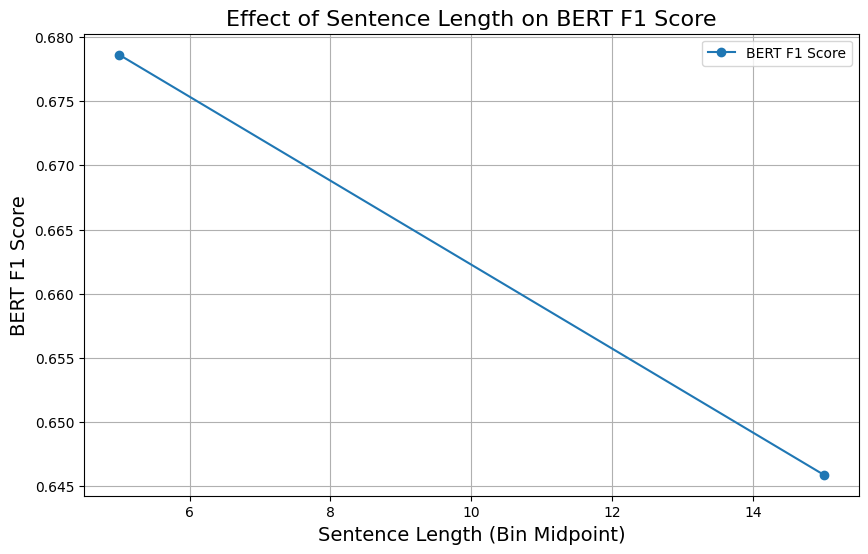

In [46]:
# Group sentences by length
def group_by_length(sentences, step=10):
    """
    Groups sentences into bins based on their length.
    Args:
        sentences: List of sentences.
        step: Bin size for grouping.
    Returns:
        Dictionary with bin midpoints as keys and list of sentences as values.
    """
    length_bins = {}
    for sentence in sentences:
        length = len(sentence.split())
        bin_key = (length // step) * step  # Group lengths in multiples of step
        if bin_key not in length_bins:
            length_bins[bin_key] = []
        length_bins[bin_key].append(sentence)
    return length_bins

# Group predictions and targets by length
step = 10
pred_groups = group_by_length(decoded_preds, step=step)
target_groups = group_by_length(decoded_targets, step=step)

# Ensure alignment of bins
common_bins = set(pred_groups.keys()) & set(target_groups.keys())

# Calculate BERTScore for each bin
bin_midpoints = []
bert_scores = []

for bin_key in sorted(common_bins):
    pred_sentences = pred_groups[bin_key]
    target_sentences = target_groups[bin_key]

    # Ensure the number of predictions and targets match
    if len(pred_sentences) != len(target_sentences):
        min_len = min(len(pred_sentences), len(target_sentences))
        pred_sentences = pred_sentences[:min_len]
        target_sentences = target_sentences[:min_len]

    # Compute BERTScore
    P, R, F1 = score(pred_sentences, target_sentences, lang="te", rescale_with_baseline=True)

    # Store results
    bin_midpoints.append(bin_key + step // 2)  # Midpoint of the bin
    bert_scores.append(F1.mean().item())  # Average F1 for the bin

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(bin_midpoints, bert_scores, marker="o", label="BERT F1 Score")
plt.xlabel("Sentence Length (Bin Midpoint)", fontsize=14)
plt.ylabel("BERT F1 Score", fontsize=14)
plt.title("Effect of Sentence Length on BERT F1 Score", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()


## We can see that Bert Score is Decreasing With Increase in Sentence Length, meaning the model doesn't work good for Longer sentences, This motivated our intrest towards Transformers for effective dealing of Long range dependencies